## Problem Set 1 - BDMLAE

In [1]:
#Packages:
import pandas as pd
import numpy as np
import pyreadr as pyr
import sklearn as sk
import scipy as sc
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns
from bootstrap_stat import bootstrap_stat as bp
from scipy.stats import bootstrap
from sklearn.impute import KNNImputer

In [2]:
#Setting work space and master data frame:
bd=pyr.read_r("bdPS1.Rdata")
print(bd.keys()) #Load database.
df0=bd["df"]
df=df0.drop(df0[df0.age<18].index) #Restrict the data to legal age individuals (age>=18).
df=df.drop(df[df.ocu==0].index) #Restrict the data to employed individuals (ocu==1).
dfsi=(df[["age", "maxEducLevel", "sizeFirm", "oficio", "hoursWorkUsual", "formal", "ingtot", "mes", "estrato1", "sex", 
"regSalud", "p6426", "p7090","p7510s7a1", "impa", "isa", "impaes", "isaes", "relab"]]) #Relevant variables selection. 

odict_keys(['df'])


In [3]:
#Reassining variables codification:
dfsi["impa"].replace(0, 1, inplace=True)
dfsi["impa"].replace(np.nan, 0, inplace=True)
dfsi["impaes"].replace(0, 1, inplace=True)
dfsi["impaes"].replace(np.nan, 0, inplace=True)
dfsi["isa"].replace(0, 1, inplace=True)
dfsi["isa"].replace(np.nan, 0, inplace=True)
dfsi["isaes"].replace(0, 1, inplace=True)
dfsi["isaes"].replace(np.nan, 0, inplace=True)

#Create compiled variables:
dfsi["impacomp"]=dfsi["impa"]+dfsi["impaes"]
dfsi["isacomp"]=dfsi["isa"]+dfsi["isaes"]

#Recover missing values: 
dfsi['impacomp']=dfsi['impacomp'].replace(0,np.nan)
dfsi['isacomp']=dfsi['isacomp'].replace(0,np.nan)
dfsi['impacomp']=dfsi['impacomp'].replace(1, 0)
dfsi['isacomp']=dfsi['isacomp'].replace(1, 0)
dfsi['impacomp']=dfsi['impacomp'].replace(2, 0)
dfsi['isacomp']=dfsi['isacomp'].replace(2, 0)

#Missing values count/share. 
dfsi.isnull().sum() 
dfsi.isnull().sum()/len(dfsi) 

C:\Users\juand\AppData\Local\Temp/ipykernel_4376/2900239718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsi["impa"].replace(0, 1, inplace=True)
C:\Users\juand\AppData\Local\Temp/ipykernel_4376/2900239718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsi["impa"].replace(np.nan, 0, inplace=True)
C:\Users\juand\AppData\Local\Temp/ipykernel_4376/2900239718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsi["impaes"].r

age               0.000000
maxEducLevel      0.000060
sizeFirm          0.000000
oficio            0.000000
hoursWorkUsual    0.000000
formal            0.000000
ingtot            0.000000
mes               0.000000
estrato1          0.000000
sex               0.000000
regSalud          0.085842
p6426             0.000000
p7090             0.000000
p7510s7a1         0.000000
impa              0.000000
isa               0.000000
impaes            0.000000
isaes             0.000000
relab             0.000000
impacomp          0.014992
isacomp           0.001874
dtype: float64

In [4]:
#Imputing missing values:
imputer=KNNImputer(n_neighbors=19) 
imputer.fit(dfsi)
dfi=pd.DataFrame(imputer.transform(dfsi))
dict=({0: "age", 1: "maxEducLevel", 2: "sizeFirm", 3: "oficio", 4: "hoursWorkUsual", 5: "formal", 6: "ingtot", 7: "mes", 8: "estrato1", 
9: "sex", 10: "regSalud", 11: "p6426", 12: "p7090", 13: "p7510s7a1", 14: "impa", 15: "isa", 16: "impaes", 17: "isaes", 18: "relab", 
19: "impacomp", 20: "isacomp"})
dfi.rename(columns=dict, inplace=True)

In [5]:
#Convert categorical variables to dummy variables:
oficio_d=pd.get_dummies(dfi["oficio"], prefix="oficio") 
sizeFirm_d=pd.get_dummies(dfi["sizeFirm"], prefix="size") 
estrato1_d=pd.get_dummies(dfi["estrato1"], prefix="estrato") 
regSalud_d=pd.get_dummies(dfi["regSalud"], prefix="regs") 
maxeduc_d=pd.get_dummies(dfi["maxEducLevel"], prefix="educ") 
relab_d=pd.get_dummies(dfi["relab"], prefix="relab") 
mes_d=pd.get_dummies(dfi["mes"], prefix="mes")

#Merge dummy's variables data frame with master data frame:
dfi=pd.merge(dfi, oficio_d, left_index=True, right_index=True) 
dfi=pd.merge(dfi, sizeFirm_d, left_index=True, right_index=True)
dfi=pd.merge(dfi, estrato1_d, left_index=True, right_index=True)
dfi=pd.merge(dfi, regSalud_d, left_index=True, right_index=True)
dfi=pd.merge(dfi, maxeduc_d, left_index=True, right_index=True)
dfi=pd.merge(dfi, relab_d, left_index=True, right_index=True)
dfi=pd.merge(dfi, mes_d, left_index=True, right_index=True)
dfi["p7090"]=np.where(dfi["p7090"]==2, 0, 1)


In [6]:
#Transform categorial atribute variables to numerical variable: 
dfi["hoursWorkUsual"]=pd.to_numeric(dfi["hoursWorkUsual"])
dfi["formal"]=pd.to_numeric(dfi["formal"])
dfi["p6426"]=pd.to_numeric(dfi["p6426"])

#Descriptive statistics data frame:
ds=(dfi[["age", "hoursWorkUsual", "p6426", "sex", "formal", "p7090", "estrato_1.0", "estrato_2.0", "estrato_3.0", 
"estrato_4.0", "estrato_5.0", "estrato_6.0", "regs_1.0", "regs_2.0", "regs_3.0", "educ_1.0", "educ_3.0", "educ_4.0", 
"educ_5.0", "educ_6.0", "educ_7.0"]].describe(include="all"))
ds=ds.T
ds=ds[["count", "mean", "std", "min", "50%", "max"]]
ds=ds.round(2)
print(ds.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &    count &   mean &    std &   min &   50\% &    max \\
\midrule
age            &  16542.0 &  39.44 &  13.48 &  18.0 &  38.0 &   94.0 \\
hoursWorkUsual &  16542.0 &  47.01 &  15.54 &   1.0 &  48.0 &  130.0 \\
p6426          &  16542.0 &  63.76 &  89.49 &   0.0 &  24.0 &  720.0 \\
sex            &  16542.0 &   0.53 &   0.50 &   0.0 &   1.0 &    1.0 \\
formal         &  16542.0 &   0.59 &   0.49 &   0.0 &   1.0 &    1.0 \\
p7090          &  16542.0 &   0.10 &   0.30 &   0.0 &   0.0 &    1.0 \\
estrato\_1.0    &  16542.0 &   0.11 &   0.31 &   0.0 &   0.0 &    1.0 \\
estrato\_2.0    &  16542.0 &   0.42 &   0.49 &   0.0 &   0.0 &    1.0 \\
estrato\_3.0    &  16542.0 &   0.36 &   0.48 &   0.0 &   0.0 &    1.0 \\
estrato\_4.0    &  16542.0 &   0.07 &   0.25 &   0.0 &   0.0 &    1.0 \\
estrato\_5.0    &  16542.0 &   0.02 &   0.14 &   0.0 &   0.0 &    1.0 \\
estrato\_6.0    &  16542.0 &   0.03 &   0.16 &   0.0 &   0.0 &    1.0 \\
regs\_1.0       &  16542.0

C:\Users\juand\AppData\Local\Temp/ipykernel_4376/2754969956.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ds.to_latex())


In [7]:
#Create dependent variable:
dfi["earnings"]=dfi["impacomp"]+dfi["isacomp"]
dfi["earnings"].describe()

count    1.654200e+04
mean     1.608618e+06
std      2.346376e+06
min      0.000000e+00
25%      7.812420e+05
50%      9.913334e+05
75%      1.566667e+06
max      5.250000e+07
Name: earnings, dtype: float64

In [8]:
#Winsorize data:
sc.stats.mstats.winsorize(dfi["earnings"], limits=[0,0.05], inplace=True)
sc.stats.mstats.winsorize(dfi["age"], limits=[0,0.05], inplace=True)
dfi["earnings"].describe()

count    1.654200e+04
mean     1.393628e+06
std      1.197830e+06
min      0.000000e+00
25%      7.812420e+05
50%      9.913334e+05
75%      1.566667e+06
max      5.000000e+06
Name: earnings, dtype: float64

In [9]:
#Create cuadratic age variable:
dfi["age2"]=dfi["age"]**2

#OLS regresion model:
y=dfi["earnings"]
x=dfi[["age", "age2"]]
x=sm.add_constant(x)
model1=sm.OLS(y,x)
results=model1.fit()
yhatp1=results.predict()
b1=results.params[1]
b2=results.params[2]
elasticidad=-b1/2*b2
print(results.summary())
print(np.sqrt(results.mse_resid))

                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     310.2
Date:                Mon, 05 Sep 2022   Prob (F-statistic):          5.83e-133
Time:                        08:21:41   Log-Likelihood:            -2.5469e+05
No. Observations:               16542   AIC:                         5.094e+05
Df Residuals:                   16539   BIC:                         5.094e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -9.33e+05    9.4e+04     -9.928      0.0

In [10]:
#Bootstrap 
seboot=[0]*3
for j in range(0,3):
    def estimador(dfi):
        y=dfi["earnings"]
        x=dfi[["age", "age2"]]
        x=sm.add_constant(x)
        model1=sm.OLS(y,x)
        results= model1.fit()
        return results.params[j]

    dist = bp.EmpiricalDistribution(dfi)
    sea=bp.standard_error(dist, estimador, B=5)
    seboot[j]=sea

In [11]:
b0=results.params[0]
b1=results.params[1]
b2=results.params[2]

b0low=b0-seboot[0]*1.96
b1low=b1-seboot[1]*1.96
b2low=b2-seboot[2]*1.96

b0upper=b0+seboot[0]*1.96
b1upper=b1+seboot[1]*1.96
b2upper=b2+seboot[2]*1.96

yhatlow=b0low+b1low*dfi['age']+b2low*dfi['age2']
yhatupper=b0upper+b1upper*dfi['age']+b2upper*dfi['age2']


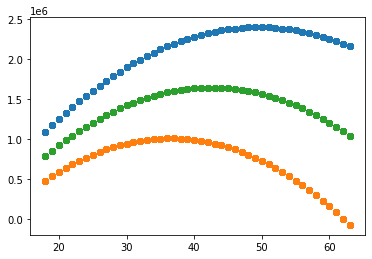

In [12]:
#Graph
fig, ax = plt.subplots()
ax.scatter(dfi['age'], yhatupper)
ax.scatter(dfi['age'], yhatlow)
ax.scatter(dfi['age'], yhatp1)
#ax.fill_between(dfi['age'], yhatlow, yhatupper, color='b', alpha=.1)

In [13]:
#Create female variable:
dfi["female"]=np.where(dfi["sex"]==1, 0, 1)
dfi=dfi.drop(dfi[dfi.earnings==0].index)
dfi["log_earnings"]=np.log(dfi["earnings"])
dfi["log_earnings"].describe()

count    16266.000000
mean        13.848315
std          0.847481
min          8.750808
25%         13.592367
50%         13.815511
75%         14.283410
max         15.424948
Name: log_earnings, dtype: float64

In [14]:
#OLS regresion model:
y=dfi["log_earnings"]
x=dfi["female"]
x=sm.add_constant(x)
model2=sm.OLS(y,x)
results= model2.fit()
print(results.summary())
print(np.sqrt(results.mse_resid))

                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     316.0
Date:                Mon, 05 Sep 2022   Prob (F-statistic):           4.97e-70
Time:                        08:21:42   Log-Likelihood:                -20232.
No. Observations:               16266   AIC:                         4.047e+04
Df Residuals:                   16264   BIC:                         4.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9577      0.009   1549.028      0.0

In [15]:
#rMSE to COP units:
y_hat=results.predict()
from math import e
y_hat2=e**(y_hat)
E = dfi["earnings"]-y_hat2
E2 = E**2
MSE=sum(E2)/(len(E2)-2)
print(np.sqrt(MSE))

1249025.8306752036


In [16]:
#Create interactions variable:
dfi["female_age"]=dfi["female"]*dfi["age"]
dfi["female_age2"]=dfi["female"]*dfi["age2"]

#OLS regresion model:
y=dfi["log_earnings"]
x=dfi[["age", "female", "female_age", "female_age2", "age2"]]
x=sm.add_constant(x)
model3=sm.OLS(y,x)
results= model3.fit()
yhatp3=results.predict()
print(results.summary())
results.params

                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     317.0
Date:                Mon, 05 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:21:42   Log-Likelihood:                -19632.
No. Observations:               16266   AIC:                         3.928e+04
Df Residuals:                   16260   BIC:                         3.932e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.0251      0.089    135.761      

const          12.025112
age             0.102177
female         -0.088458
female_age      0.006645
female_age2    -0.000252
age2           -0.001213
dtype: float64

In [17]:
#rMSE to COP units:
y_hat=results.predict()
from math import e
y_hat2=e**(y_hat)
E = dfi["earnings"]-y_hat2
E2 = E**2
MSE=sum(E2)/(len(E2)-6)
print(np.sqrt(MSE))

1221026.851353383


In [59]:
#Bootstrap 
seboot=[0]*6
for j in range(0,6):
    def estimador3(dfi):
        y=dfi["log_earnings"]
        x=dfi[["age", "female", "female_age", "female_age2", "age2"]]
        x=sm.add_constant(x)
        model1=sm.OLS(y,x)
        results= model1.fit()
        return results.params[j]

    dist = bp.EmpiricalDistribution(dfi)
    sea=bp.standard_error(dist, estimador3, B=5)
    seboot[j]=sea

seboot


[0.06991043903223722,
 0.00386172880974384,
 0.12944378231098908,
 0.01398908412642289,
 0.00010250392480243745,
 6.27271250728658e-05]

In [60]:

for k in range(0,6):
    locals()['b'+str(k)]=results.params[k]
    locals()['b'+str(k)+'low']=locals()['b'+str(k)]-seboot[k]*1.96
    locals()['b'+str(k)+'upper']=locals()['b'+str(k)]+seboot[k]*1.96


yhatlow=b0low+b1low*dfi['age']+b5low*dfi['age2']+b2low*dfi['female']+b3low*dfi['female_age']+b4low*dfi['female_age2']
yhatupper=b0upper+b1upper*dfi['age']+b5upper*dfi['age2']+b2upper*dfi['female']+b3upper*dfi['female_age']+b4upper*dfi['female_age2']


AttributeError: 'LinearRegression' object has no attribute 'params'

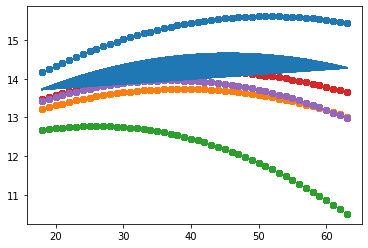

In [52]:
#Graph

yhatupperh= np.ma.masked_where(dfi['female']==0, yhatupper)
yhatlowh = np.ma.masked_where(dfi['female']==0, yhatlow)

yhatupperm= np.ma.masked_where(dfi['female']==1, yhatupper)
yhatlowm = np.ma.masked_where(dfi['female']==1,yhatlow )

yhatp3m=np.ma.masked_where(dfi['female']==1, yhatp3)
yhatp3h=np.ma.masked_where(dfi['female']==0, yhatp3)

fig, ax = plt.subplots()
ax.scatter(dfi['age'], yhatupperm)
ax.scatter(dfi['age'], yhatupperh)
ax.scatter(dfi['age'], yhatlowm)
ax.scatter(dfi['age'], yhatlowh)
ax.scatter(dfi['age'], yhatp3m)
ax.scatter(dfi['age'], yhatp3h)
#ax.fill_between(dfi['age'], yhatlow, yhatupper, color='b', alpha=.1)

In [21]:
oficio=["oficio_1.0"]
for i in range(2,99):
    oficio.append("oficio_"+str(i)+".0")
    list1=['oficio_10.0', 'oficio_22.0', 'oficio_23.0', 'oficio_24.0', 'oficio_25.0', 'oficio_26.0', 'oficio_27.0', 'oficio_28.0', 'oficio_29.0', 'oficio_46.0', 'oficio_47.0', 'oficio_48.0', 'oficio_64.0', 'oficio_65.0', 'oficio_66.0', 'oficio_67.0', 'oficio_68.0', 'oficio_69.0', 'oficio_71.0']
    oficio2=[i for i in oficio if i not in list1]

#Long regression
#Define exogenous and endogenous variables:
y=dfi["log_earnings"]
x0=dfi[["female", "age", "age2", "female_age", "female_age2"]]
x1=(dfi[["sizeFirm", "hoursWorkUsual", "formal", "p6426", "educ_3.0", "educ_4.0", 
"educ_5.0", "educ_6.0", "educ_7.0", "relab_2.0", "relab_3.0" , "relab_4.0", "relab_5.0", "relab_6.0", 
"relab_7.0", "relab_8.0" , "relab_9.0", "mes_1.0", "mes_2.0", "mes_3.0", "mes_4.0", "mes_5.0", "mes_6.0", 
"mes_7.0", "mes_9.0", "mes_10.0", "mes_11.0", "mes_12.0"]])
x2=dfi[oficio2]
x=pd.concat([x0,x1,x2], axis=1, join="inner")
x=sm.add_constant(x)

#OLS regresion model:
model2=sm.OLS(y,x)
results= model2.fit()
print(results.summary())
print(np.sqrt(results.mse_resid))

                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     179.4
Date:                Mon, 05 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:22:39   Log-Likelihood:                -13815.
No. Observations:               16266   AIC:                         2.786e+04
Df Residuals:                   16153   BIC:                         2.873e+04
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.9644      0.100    110.

In [22]:

#rMSE to COP units:
y_hat=results.predict()
from math import e
y_hat2=e**(y_hat)
E = dfi["earnings"]-y_hat2
E2 = E**2
MSE=sum(E2)/(len(E2)-131)
print(np.sqrt(MSE))

866461.508742896


In [23]:
#FWL theorem
#Define exog and endog variables
y=dfi["log_earnings"]
x0=dfi[["female", "age", "age2", "female_age", "female_age2"]]
x_f=pd.concat([x1,x2], axis=1, join="inner")
x_f=sm.add_constant(x_f)
x0=sm.add_constant(x0)

#Residuals of log_earnings regressed on controls
model3=sm.OLS(y,x_f)
results_f= model3.fit()
resid_a=results_f.resid

#residuals of female regressed on controls
model4=sm.OLS(x0, x_f)
results_f2= model4.fit()
resid_b=results_f2.resid

#Delete constant from residuals b
resid_b=resid_b.drop(["const"], axis=1)

#Results of resid_a  regressed on resid_b
model_FWL=sm.OLS(resid_a,resid_b)
results_FWL=model_FWL.fit()
print(results_FWL.summary())
print(np.sqrt(results.mse_resid))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.043
Model:                            OLS   Adj. R-squared (uncentered):              0.043
Method:                 Least Squares   F-statistic:                              145.5
Date:                Mon, 05 Sep 2022   Prob (F-statistic):                   1.41e-151
Time:                        08:22:49   Log-Likelihood:                         -13815.
No. Observations:               16266   AIC:                                  2.764e+04
Df Residuals:                   16261   BIC:                                  2.768e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [24]:
#rMSE to COP units:
y_hat=results.predict()
from math import e
y_hat2=e**(y_hat)
E = dfi["earnings"]-y_hat2
E2 = E**2
MSE=sum(E2)/(len(E2)-5)
print(np.sqrt(MSE))

863098.048310414


In [ ]:
#Bootstrap FWL



In [25]:
#Create new variables
dfi['age_hours']=dfi['age']*dfi['hoursWorkUsual']
dfi['hours2']=dfi['hoursWorkUsual']**2
dfi['age_hours2']=dfi['age']*dfi['hours2']

for j in range(1,8):
    if j==2:
        pass
    else:
        dfi["female_educ"+str(j)]=dfi["female"]*dfi["educ_"+str(j)+".0"]

for j in range(1,10):
        dfi["female_relab"+str(j)]=dfi['female']*dfi["relab_"+str(j)+".0"]

for j in range(1,8):
    if j==2:
        pass
    else:
        dfi["age_educ"+str(j)]=dfi["age"]*dfi["educ_"+str(j)+".0"]

In [26]:
#Create new variables
dfi["p6426_2"]=dfi["p6426"]**2
dfi["p6426_3"]=dfi["p6426"]**3
dfi["p6426_age"]=dfi["p6426"]*dfi["age"]
dfi["p6426_2_age"]=dfi["p6426_2"]*dfi["age"]
dfi["p6426_3_age"]=dfi["p6426_3"]*dfi["age"]


In [27]:
#Prediction
#Split the data
dfi_train, dfi_test = train_test_split(
                                dfi,
                                test_size=.3, 
                                random_state=911)

In [28]:
#Define X matrix
oficio=["oficio_1.0"]
for i in range(2,99):
    oficio.append("oficio_"+str(i)+".0")
    list1=['oficio_10.0', 'oficio_22.0', 'oficio_23.0', 'oficio_24.0', 'oficio_25.0', 'oficio_26.0', 'oficio_27.0', 'oficio_28.0', 'oficio_29.0', 'oficio_46.0', 'oficio_47.0', 'oficio_48.0', 'oficio_64.0', 'oficio_65.0', 'oficio_66.0', 'oficio_67.0', 'oficio_68.0', 'oficio_69.0', 'oficio_71.0']
    oficio2=[i for i in oficio if i not in list1]

x1=(dfi_train[["sizeFirm", "hoursWorkUsual", "formal", "p6426", "educ_3.0", "educ_4.0", 
"educ_5.0", "educ_6.0", "educ_7.0", "relab_2.0", "relab_3.0" , "relab_4.0", "relab_5.0", "relab_6.0", 
"relab_7.0", "relab_8.0" , "relab_9.0", "mes_1.0", "mes_2.0", "mes_3.0", "mes_4.0", "mes_5.0", "mes_6.0", 
"mes_7.0", "mes_9.0", "mes_10.0", "mes_11.0", "mes_12.0"]])
x2=dfi_train[oficio2]
X_train=pd.concat([x1,x2], axis=1, join="inner")


x11=(dfi_test[["sizeFirm", "hoursWorkUsual", "formal", "p6426", "educ_3.0", "educ_4.0", 
"educ_5.0", "educ_6.0", "educ_7.0", "relab_2.0", "relab_3.0" , "relab_4.0", "relab_5.0", "relab_6.0", 
"relab_7.0", "relab_8.0" , "relab_9.0", "mes_1.0", "mes_2.0", "mes_3.0", "mes_4.0", "mes_5.0", "mes_6.0", 
"mes_7.0", "mes_9.0", "mes_10.0", "mes_11.0", "mes_12.0"]])
x22=dfi_test[oficio2]
X_test=pd.concat([x11,x22], axis=1, join="inner")



In [41]:
rmsemodels=[0]*10

#Models
#Model 1 earnings age age2
y_train=dfi_train["earnings"]
y_test=dfi_test["earnings"]
x_train=dfi_train[["age", "age2"]]
x_test=dfi_test[["age", "age2"]]
model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)

rmse1=mean_squared_error(y_test,y_hattest, squared=False)
rmse1
rmsemodels[0]=rmse1
rmse1

1179468.9441737835

In [42]:
#Models  
#Model 2 log_earnings female
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]
x_train=dfi_train[["female"]]
x_test=dfi_test[["female"]]
model2=LinearRegression(fit_intercept=True)
results2= model2.fit(x_train,y_train)
y_hattest=results2.predict(x_test)
rmse2=mean_squared_error(y_test,y_hattest, squared=False)
rmse2
rmsemodels[1]=rmse2

In [43]:
#Models 
#Model 3 log_earnings female age age2 agefemale agefemale
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]
x_train=dfi_train[["female", "age", "age2", "female_age", "female_age2"]]
x_test=dfi_test[["female", "age", "age2", "female_age", "female_age2"]]
model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse3=mean_squared_error(y_test,y_hattest, squared=False)
rmse3
rmsemodels[2]=rmse3

In [44]:
#Models 
#Model 4 log_earnings female age age2 agefemale agefemale X
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]



x_trainsub=dfi_train[["female", "age", "age2", "female_age", "female_age2"]]
x_testsub=dfi_test[["female", "age", "age2", "female_age", "female_age2"]]

x_train=pd.concat([X_train,x_trainsub], axis=1, join="inner")
x_test=pd.concat([X_test,x_testsub], axis=1, join="inner")

model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse4=mean_squared_error(y_test,y_hattest, squared=False)
rmse4

rmsemodels[3]=rmse4

In [47]:
#Models 
#Model 5 age age2 hoursworkusual hoursworkusual2 agehoursworkusual agehoursworkusual2 X
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]


x_trainsub=dfi_train[["age", "age2", "hoursWorkUsual", "hours2", "age_hours" , "age_hours2"]]
x_testsub=dfi_test[["age", "age2", "hoursWorkUsual", "hours2", "age_hours" , "age_hours2"]]

x_train=pd.concat([X_train,x_trainsub], axis=1, join="inner")
x_test=pd.concat([X_test,x_testsub], axis=1, join="inner")

model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse5=mean_squared_error(y_test,y_hattest, squared=False)
rmse5

rmsemodels[4]=rmse5


In [56]:
#Models 
#Model 6 age age2 female educ relab formal oficio p7090 mes reg_salud estrato 
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]


educ=["educ_1.0"]
for i in range(1,8):
    educ.append("educ_"+str(i)+".0")
    list1=['educ_2.0']
    educ2=[i for i in educ if i not in list1]
x_et=dfi_train[educ2]
x_ett=dfi_test[educ2]

relab=["relab_1.0"]
for i in range(1,10):
    relab.append("relab_"+str(i)+".0")
x_ret=dfi_train[relab]
x_rett=dfi_test[relab]

   
regs=["regs_1.0"]
for i in range(1,4):
    regs.append("regs_"+str(i)+".0")
x_regt=dfi_train[regs]
x_regtt=dfi_test[regs]


estrato2=["estrato_1.0"]
for i in range(1,7):
    estrato2.append("estrato_"+str(i)+".0")
x_est=dfi_train[estrato2]
x_estt=dfi_test[estrato2]

mes2=["mes_1.0"]
for i in range(1,8):
    mes2.append("mes_"+str(i)+".0")
x_mest=dfi_train[mes2]
x_mestt=dfi_test[mes2]

oficio=["oficio_1.0"]
for i in range(2,99):
    oficio.append("oficio_"+str(i)+".0")
    list1=['oficio_10.0', 'oficio_22.0', 'oficio_23.0', 'oficio_24.0', 'oficio_25.0', 'oficio_26.0', 'oficio_27.0', 'oficio_28.0', 'oficio_29.0', 'oficio_46.0', 'oficio_47.0', 'oficio_48.0', 'oficio_64.0', 'oficio_65.0', 'oficio_66.0', 'oficio_67.0', 'oficio_68.0', 'oficio_69.0', 'oficio_71.0']
    oficio2=[i for i in oficio if i not in list1]
x_oficiot=dfi_train[oficio2]
x_oficiott=dfi_test[oficio2]


x_trainsub=dfi_train[["age", "age2", "female", "formal" , "p7090" ]]
x_testsub=dfi_test[["age", "age2", "female", "formal" , "p7090" ]]



x_train=pd.concat([x_et, x_ret, x_regt, x_est, x_mest, x_oficiot,x_trainsub], axis=1, join="inner")
x_test=pd.concat([x_ett, x_rett, x_regtt, x_estt, x_mestt, x_oficiott,x_trainsub], axis=1, join="inner")



In [ ]:
#Run Model 6
model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse5=mean_squared_error(y_test,y_hattest, squared=False)
rmse6

rmsemodels[5]=rmse6

In [ ]:
#Models 
#Model 7 age age2 female educ femalexeduc p7090 femalexrelab relab X
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]

relab2=["relab_1.0"]
for i in range(1,10):
    relab2.append("relab_"+str(i)+".0")
x_ret=dfi_train[relab2]
x_rett=dfi_test[relab2]



x_trainsub=dfi_train[["age", "age2", "female" , "educ" , "p7090"]]
x_testsub=dfi_test[["age", "age2", "hoursworkusual", "hours2", "age_hours" , "age_hours2"]]

x_train=pd.concat([X_train, x_ret ,x_trainsub], axis=1, join="inner")
x_test=pd.concat([X_test, x_rett ,x_testsub], axis=1, join="inner")

model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse7=mean_squared_error(y_test,y_hattest, squared=False)
rmse7

rmsemodels[6]=rmse7

In [ ]:
#Models 
#Model 8 age age2 p7510s1a1 p7510s7a1 p7090 X
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]


x_trainsub=dfi_train[["age", "age2", "p7510s1a1" , "p7510s7a1" , "p7090"]]
x_testsub=dfi_test[["age", "age2", "p7510s1a1" , "p7510s7a1" , "p7090"]]

x_train=pd.concat([X_train,x_trainsub], axis=1, join="inner")
x_test=pd.concat([X_test, x_testsub], axis=1, join="inner")

model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse8=mean_squared_error(y_test,y_hattest, squared=False)
rmse8

rmsemodels[7]=rmse8

In [ ]:
#Models 
#Model 9 p6426 p6426_2 p6426_3 age p7090 age2 p6426Xage p6426_2age p6426_3age  X
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]


x_trainsub=dfi_train[["p6426" , "p6426_2" , "p6426_3" , "age" , "age2" , "p6426_age" , "p6426_2_age" , "p6426_3_age"]]
x_testsub=dfi_test[["p6426" , "p6426_2" , "p6426_3" , "age" , "age2" , "p6426_age" , "p6426_2_age" , "p6426_3_age"]]

x_train=pd.concat([X_train,x_trainsub], axis=1, join="inner")
x_test=pd.concat([X_test, x_testsub], axis=1, join="inner")

model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse8=mean_squared_error(y_test,y_hattest, squared=False)
rmse8

rmsemodels[7]=rmse8

In [ ]:
#Models 
#Model 10  agexeduc educ age p7090 age2 X
y_train=dfi_train["log_earnings"]
y_test=dfi_test["log_earnings"]



x_trainsub=dfi_train[["educ" , "age" , "p7090" , "age2"]]
x_trainsub=dfi_train[["educ" , "age" , "p7090" , "age2"]]

x_train=pd.concat([X_train,x_trainsub], axis=1, join="inner")
x_test=pd.concat([X_test, x_testsub], axis=1, join="inner")

model1=LinearRegression(fit_intercept=True)
results= model1.fit(x_train,y_train)
y_hattest=results.predict(x_test)
rmse10=mean_squared_error(y_test,y_hattest, squared=False)
rmse10

rmsemodels[9]=rmse10